## Группа DS03-onl

Студент Парфимович Алексей

## Домашнее задание №14
- Проанализировать данные по выживаемости пассажиров титаника. 
- Обучить модель предсказания выживет ли человек или нет (ключевая переменная) 
- Определить наиболее значимые переменные которые влияют на выживаемость. 
- Визуализировать дерево решений. 
- Написать вывод. 

(различные варианты визуализации можно посмотреть здесь https://www.kaggle.com/competitions/titanic/code?competitionId=3136&sortBy=scoreDescending&language=Python).

Ответить на вопросы (обоснованно):
1. Как влияет размер семьи  на вероятность виживаемости (одинокие выживают чаще или нет?, люди у которых большая семья (больше 4) выживают чаще или нет).
2. Как влияет пол/возраст/номер палубы. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
from math import nan

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn import tree


TRAIN_CSV_PATH = 'titanic_train.csv'
TEST_CSV_PATH = 'titanic_test.csv'

- PassengerId — id пассажира
- Survived — погиб (0) или выжил (1)
- Pclass — класс билета (первый (1), второй (2) или третий (3))
- Name — имя пассажира
- Sex — пол
- Age — возраст
- SibSp — количество братьев и сестер или супругов на борту
- Parch — количество родителей и детей на борту
- Ticket — номер билета
- Fare — стоимость билета
- Cabin — номер каюты
- Embarked — порт посадки (C — Шербур; Q — Квинстаун; S — Саутгемптон)

In [2]:
def process_data(df:pd.DataFrame):
 
    # Для признака "Cabin" - часть пропущенных значений заменить совпадающими по номеру билета (по одному билету может быть зарегистрирована группа пассажиров)
    df['Cabin'] = df.groupby(['Ticket'])['Cabin'].transform(lambda x: x.fillna(x.mode()[0] if x.count()>0 else nan))

    # Выделить из признака "Cabin"(номер каюты) палубу "Deck"
    df.insert(10,'Deck', df['Cabin'].str.extract(r'(\D+)', expand = True)[0])
    # Исключить из признака ошибочные буквы, например "f e"  или "f g" - при этом использовать последнюю букву 
    df['Deck'] = df['Deck'].str[-1:]

    # Выделить из признака Name новый признак Title(титул-приставка к имени пассажира)
    df.insert(2,'Title', df['Name'].str.extract(r' (\w+)\.', expand = True)[0] )
    df.loc[df['Title'].isin(['capt','col','major']), 'Title'] = 'military'
    df.loc[df['Title'].isin(['lady','donа','countess']), 'Title'] = 'lady'
    df.loc[df['Title'].isin(['sir','don','jonkheer']), 'Title'] = 'sir'
    df.loc[df['Title'].isin(['ms','mlle']), 'Title'] = 'miss'
    df.loc[df['Title'].isin(['mme']), 'Title'] = 'mrs'

    # Для признака "Age" - заменить пропущенные значения медианным значением группы по признаку 'Title'(титул)
    df['Age'] = df.groupby(['Title'])['Age'].transform(lambda x: x.fillna(x.median() if x.count()>0 else nan))
    # ВЫделить признак возрастной категории - до 1 года, до 10 лет, и т.д.
    df.insert(6,'Age_category', df['Age'])
    df['Age_category'] = df['Age_category'].transform(lambda x: round(x,-1)+10 if x > 1 else 1)

    #df.insert(9,'Relatives', df['SibSp'] + df['Parch'] +1)

    # Выделить признак количества пассажиров зарегистрированных по одному билету
    df.insert(10,'Persons_per_ticket', df.groupby('Ticket')['Fare'].transform('count'))
    # Заменить значения 0 на 1
    df['Persons_per_ticket'] = df['Persons_per_ticket'].apply(lambda x: 1 if x == 0 else x)

    # Выделить признак стоимости одного проездного места в билете
    df.insert(11,'Price_per_person', (df['Fare'] / df['Persons_per_ticket']).round(decimals=2))
    df['Price_per_person'] = df.groupby(['Pclass'])['Price_per_person'].transform(lambda x: x.fillna(x.median() if x.count()>0 else 0))

    # Для признака "Deck" часть пропущенных значений заменить совпадающими по классу и стоимости места
    df['Deck'] = df.groupby(['Pclass','Price_per_person'])['Deck'].transform(lambda x: x.fillna(x.mode()[0] if x.count()>0 else nan))
    # Значения не соответсвующие ни одной из палуб корабля отнести к категории Unknown
    df['Deck'] = df['Deck'].apply(lambda x: 'unknown' if x not in ['a','b','c','d','e','f','g'] else x)
    # Оставшиеся пропущенные значения отнести к категории Unknown
    df['Deck'].fillna('unknown', inplace=True)

    # Для признака "Embarked" - заменить пропущенные значения наиболее частым значением данного признака
    df['Embarked'].fillna(df.mode()['Embarked'][0], inplace=True)

    return df

Загрузка и обработка обучающего набора данных

In [3]:
df_raw = pd.read_csv(TRAIN_CSV_PATH, sep=',')

# Привести все строковые значения к единому регистру, 
df_raw = df_raw.apply(lambda x: x.astype(str).str.lower() if x.dtype.name=='object' else x)
# Удалить столбец 'PassengerId'
df_raw.drop(['PassengerId'],axis=1, inplace=True)
# Заменить значения "nan" на NULL/NAN для полей содрежащих строки
df_raw.replace('nan', nan, inplace=True)
# Заменить значения 0 на NULL/NAN для поля возраста стоимости билета
df_raw['Age'].replace(0, nan, inplace=True)

df_train = process_data(df_raw)

Анализ данных

Text(0.5, 1.0, 'Выживаемость пассажиров в зависимости от количества братьев/сестер/супругов')

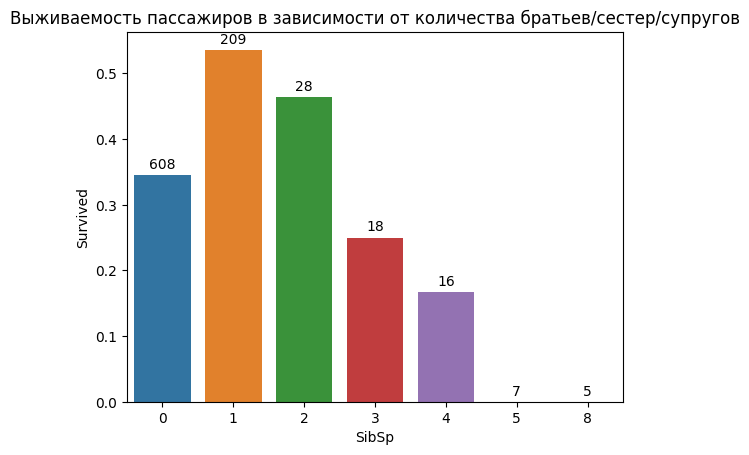

In [4]:
# Распределение пассажиров по количеству братьев/сестер/супругов
values = df_train['SibSp'].value_counts().values
# Выживаемость пассажиров в ззависимости от количества братьев/сестер/супругов
bp = sns.barplot (data = df_train, x = 'SibSp', y = 'Survived', ci = None)

# Выведем на график количество пассажиров каждой категории
for i, p in enumerate(bp.patches):
    height = p.get_height()
    bp.text(p.get_x()+p.get_width()/2., height+0.01, values[i], ha="center")

plt.title('Выживаемость пассажиров в зависимости от количества братьев/сестер/супругов')

Вывод: 
- Наличие супруга или 1-2-х братьев или сестер увеличиет шанс выживаемости - родственники помогают друг-другу
- В тоже время, если количество родственников больше 3-х то шанс выживаемости одного из них снижается

Text(0.5, 1.0, 'Выживаемость пассажиров в зависимости от наличия родителей / количества детей')

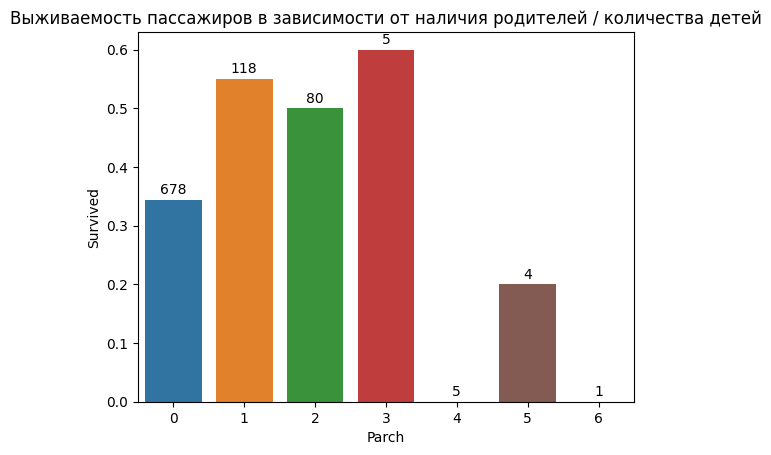

In [5]:
# Распределение пассажиров по наличию родителей / количеству детей
values = df_train['Parch'].value_counts().values
# Выживаемость пассажиров в ззависимости от наличия родителей / количества детей
bp = sns.barplot (data = df_train, x = 'Parch', y = 'Survived', ci = None)

# Выведем на график количество пассажиров каждой категории
for i, p in enumerate(bp.patches):
    height = p.get_height()
    bp.text(p.get_x()+p.get_width()/2., height+0.01, values[i], ha="center")

plt.title('Выживаемость пассажиров в зависимости от наличия родителей / количества детей')

Вывод: 
- Наличие родителя на борту увеличиет шанс выживаемости
- Интересно что количество выживших близких родственников не снижается в увеличением их количества

Text(0.5, 1.0, 'Выживаемость пассажиров в зависимости от количества зарегистрированных на один билет')

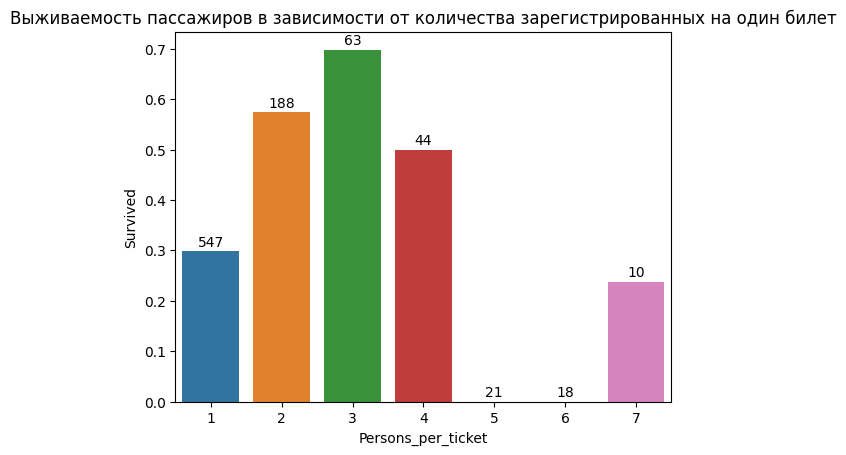

In [6]:
# Распределение пассажиров по количеству зарегистрированных на один билет
values = df_train['Persons_per_ticket'].value_counts().values
# Выживаемость пассажиров в ззависимости от количества зарегистрированных на один билет
bp = sns.barplot (data = df_train, x = 'Persons_per_ticket', y = 'Survived', ci = None)

# Выведем на график количество пассажиров каждой категории
for i, p in enumerate(bp.patches):
    height = p.get_height()
    bp.text(p.get_x()+p.get_width()/2., height+0.01, values[i], ha="center")

plt.title('Выживаемость пассажиров в зависимости от количества зарегистрированных на один билет')

Вывод: 
- Наличие друзей, близких знакомых или родственников однозначно увеличивет шанс на выживание
- Оборатите внимание на "сплоченную команду в полосатых купальниках" в правом углу графика

Text(0.5, 1.0, 'Выживаемость пассажиров в зависимости от пола и гражданского статуса)')

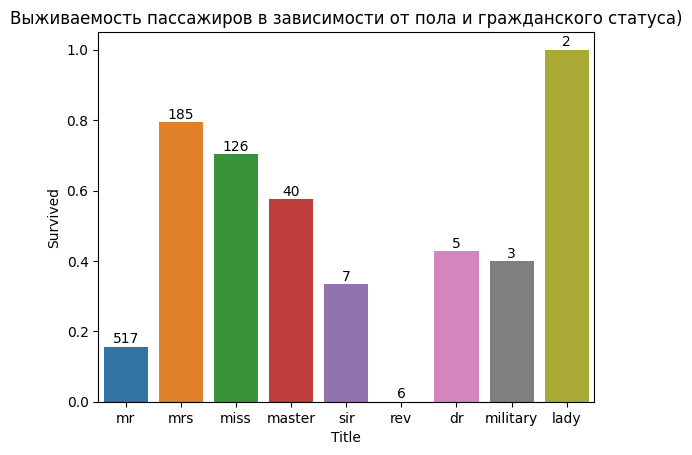

In [7]:
# Распределение пассажиров по полу и гражданскому статусу
values = df_train['Title'].value_counts().values
# Выживаемость пассажиров в зависимости от пола и гражданского статуса
bp = sns.barplot (data = df_train, x = 'Title', y = 'Survived', ci = None)

# Выведем на график количество пассажиров каждой категории статуса
for i, p in enumerate(bp.patches):
    height = p.get_height()
    bp.text(p.get_x()+p.get_width()/2., height+0.01, values[i], ha="center")

plt.title('Выживаемость пассажиров в зависимости от пола и гражданского статуса)')

Вывод: 
- Очевидно что пол пассажира существенно влияет на выживаемость - женщин выжило существенно больше чем мужчин, хотя их общее количество существенно меньше
- Посмотрим на выживаемость относительно гражданского статуса пассажира - шанс у детей(miss/master), а также "военных", "ученых" и "благородных"(sir/lady) выше, но при этом из священников(rev) не выжил никто 

Text(0.5, 1.0, 'Выживаемость пассажиров в зависимости от расположения каюты)')

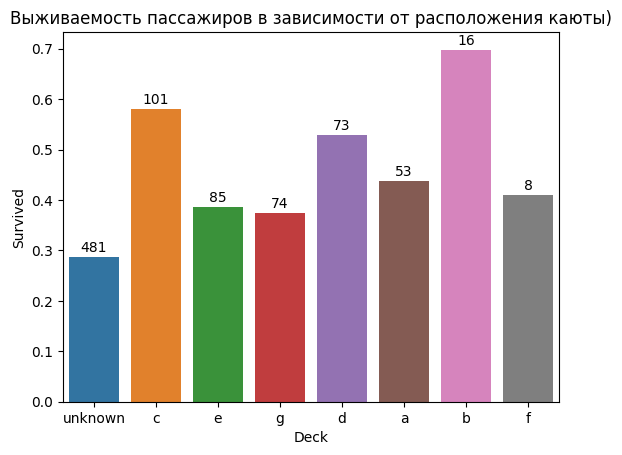

In [8]:
# Распределение пассажиров по расположению каюты (палуба)
values = df_train['Deck'].value_counts().values
# Выживаемость пассажиров в ззависимости от расположения каюты (палуба)
bp = sns.barplot (data = df_train, x = 'Deck', y = 'Survived', ci = None)

# Выведем на график количество пассажиров для каждой палубы
for i, p in enumerate(bp.patches):
    height = p.get_height()
    bp.text(p.get_x()+p.get_width()/2., height+0.01, values[i], ha="center")

plt.title('Выживаемость пассажиров в зависимости от расположения каюты)')

Вывод: 
- В виду отсутствия данных о расположении кают для больше части пассажиров - явных зависимостей между выживанием и палубой каюты выявлено не было 

Text(0.5, 1.0, 'Выживаемость пассажиров в зависимости от возраста)')

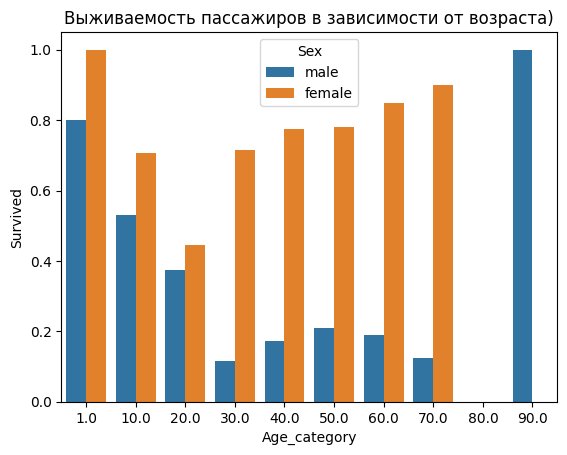

In [9]:
# Выживаемость пассажиров в зависимости возраста
bp = sns.barplot (data = df_train, x = 'Age_category', y = 'Survived', hue='Sex', ci = None)

plt.title('Выживаемость пассажиров в зависимости от возраста)')

Вывод: 
- Шанс на выживание снижается с ростом возраста пассажира до 20 лет (дети и подростки),
- Далее он немного возрастает с увеличением возраста до 50 (эффект старшинства?), после чего опять снижается (здоровье?)
- Тенденция сожраняется как для мужчин, так и для женщин

Подготовка данных для обучения модели

In [10]:
# Исключаем из обучения поля 'Name','Ticket','Fare','Cabin'
num_cols = ['Age','SibSp','Parch','Persons_per_ticket','Price_per_person']
cat_cols = ['Survived','Pclass', 'Title', 'Sex', 'Deck', 'Embarked']

data = pd.concat((df_train[num_cols], pd.get_dummies(df_train[cat_cols])), axis=1)

y_train = data['Survived']
X_train = data.drop(['Survived'], axis=1)

Обучение модели на основе алгоритма RandomForestClassifier

In [11]:
rfc = (RandomForestClassifier)()
                                
rfc.fit(X_train, y_train);

print('AUC на обучающей выборке: {:.3f}'.
      format(roc_auc_score(y_train, rfc.predict_proba(X_train)[:, 1])))

AUC на обучающей выборке: 0.997


Диаграмма важности признаков

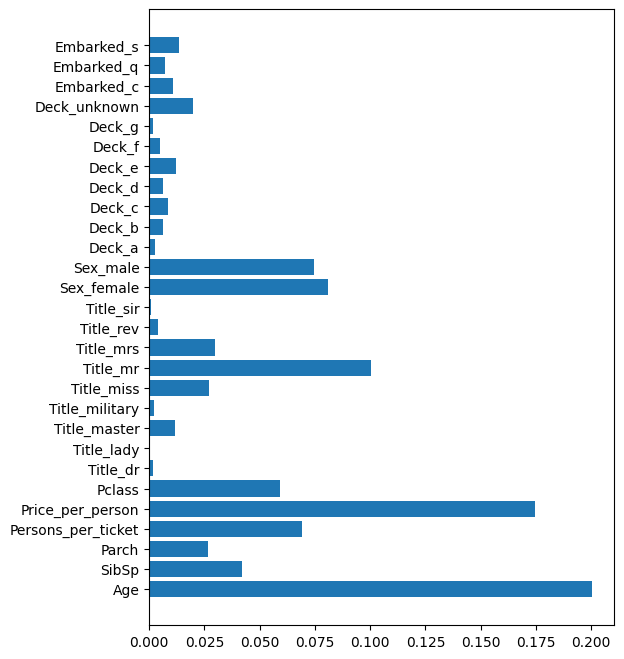

In [12]:
plt.figure(figsize=(6,8))
plt.barh(np.arange(len(rfc.feature_importances_)), rfc.feature_importances_)
plt.yticks(np.arange(len(X_train.columns)),X_train.columns);

Вывод: 
- Наиболее начимыми признаками являются Возраст, Стоимость проезда, Гражданский статус Mr (мужчина среднего и низшего класса), а также пол пассажиров 

Выполним обучение модели на основе алгоритма DecisionTreeClassifier

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)

print('AUC на обучающей выборке: {:.3f}'.
    format(accuracy_score(y_train, dtc.predict(X_train))))

AUC на обучающей выборке: 0.982


Выполним подбор гиперпараметров модели

In [14]:
params = {'max_depth': range (2, 21, 1)}

dtc_gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=params, n_jobs=-1, cv=5, verbose=5)
dtc_gridsearch.fit(X_train,y_train)

print('Best Parameters : {}'.format(dtc_gridsearch.best_params_))
print('Best Accuracy Through Grid Search : {:.3f}\n'.format(dtc_gridsearch.best_score_))
print('AUC на обучающей выборке: {:.3f}'.
    format(accuracy_score(y_train, dtc_gridsearch.predict(X_train))))

Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best Parameters : {'max_depth': 7}
Best Accuracy Through Grid Search : 0.811

AUC на обучающей выборке: 0.899


Построим  диаграмму важности признаков

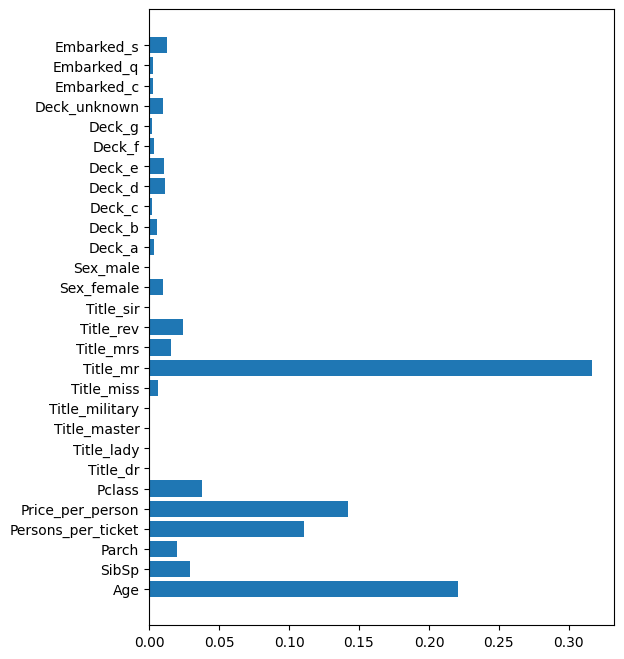

In [15]:
plt.figure(figsize=(6,8))
plt.barh(np.arange(len(dtc.feature_importances_)), dtc.feature_importances_)
plt.yticks(np.arange(len(X_train.columns)),X_train.columns);

Визуализируем дерево решений

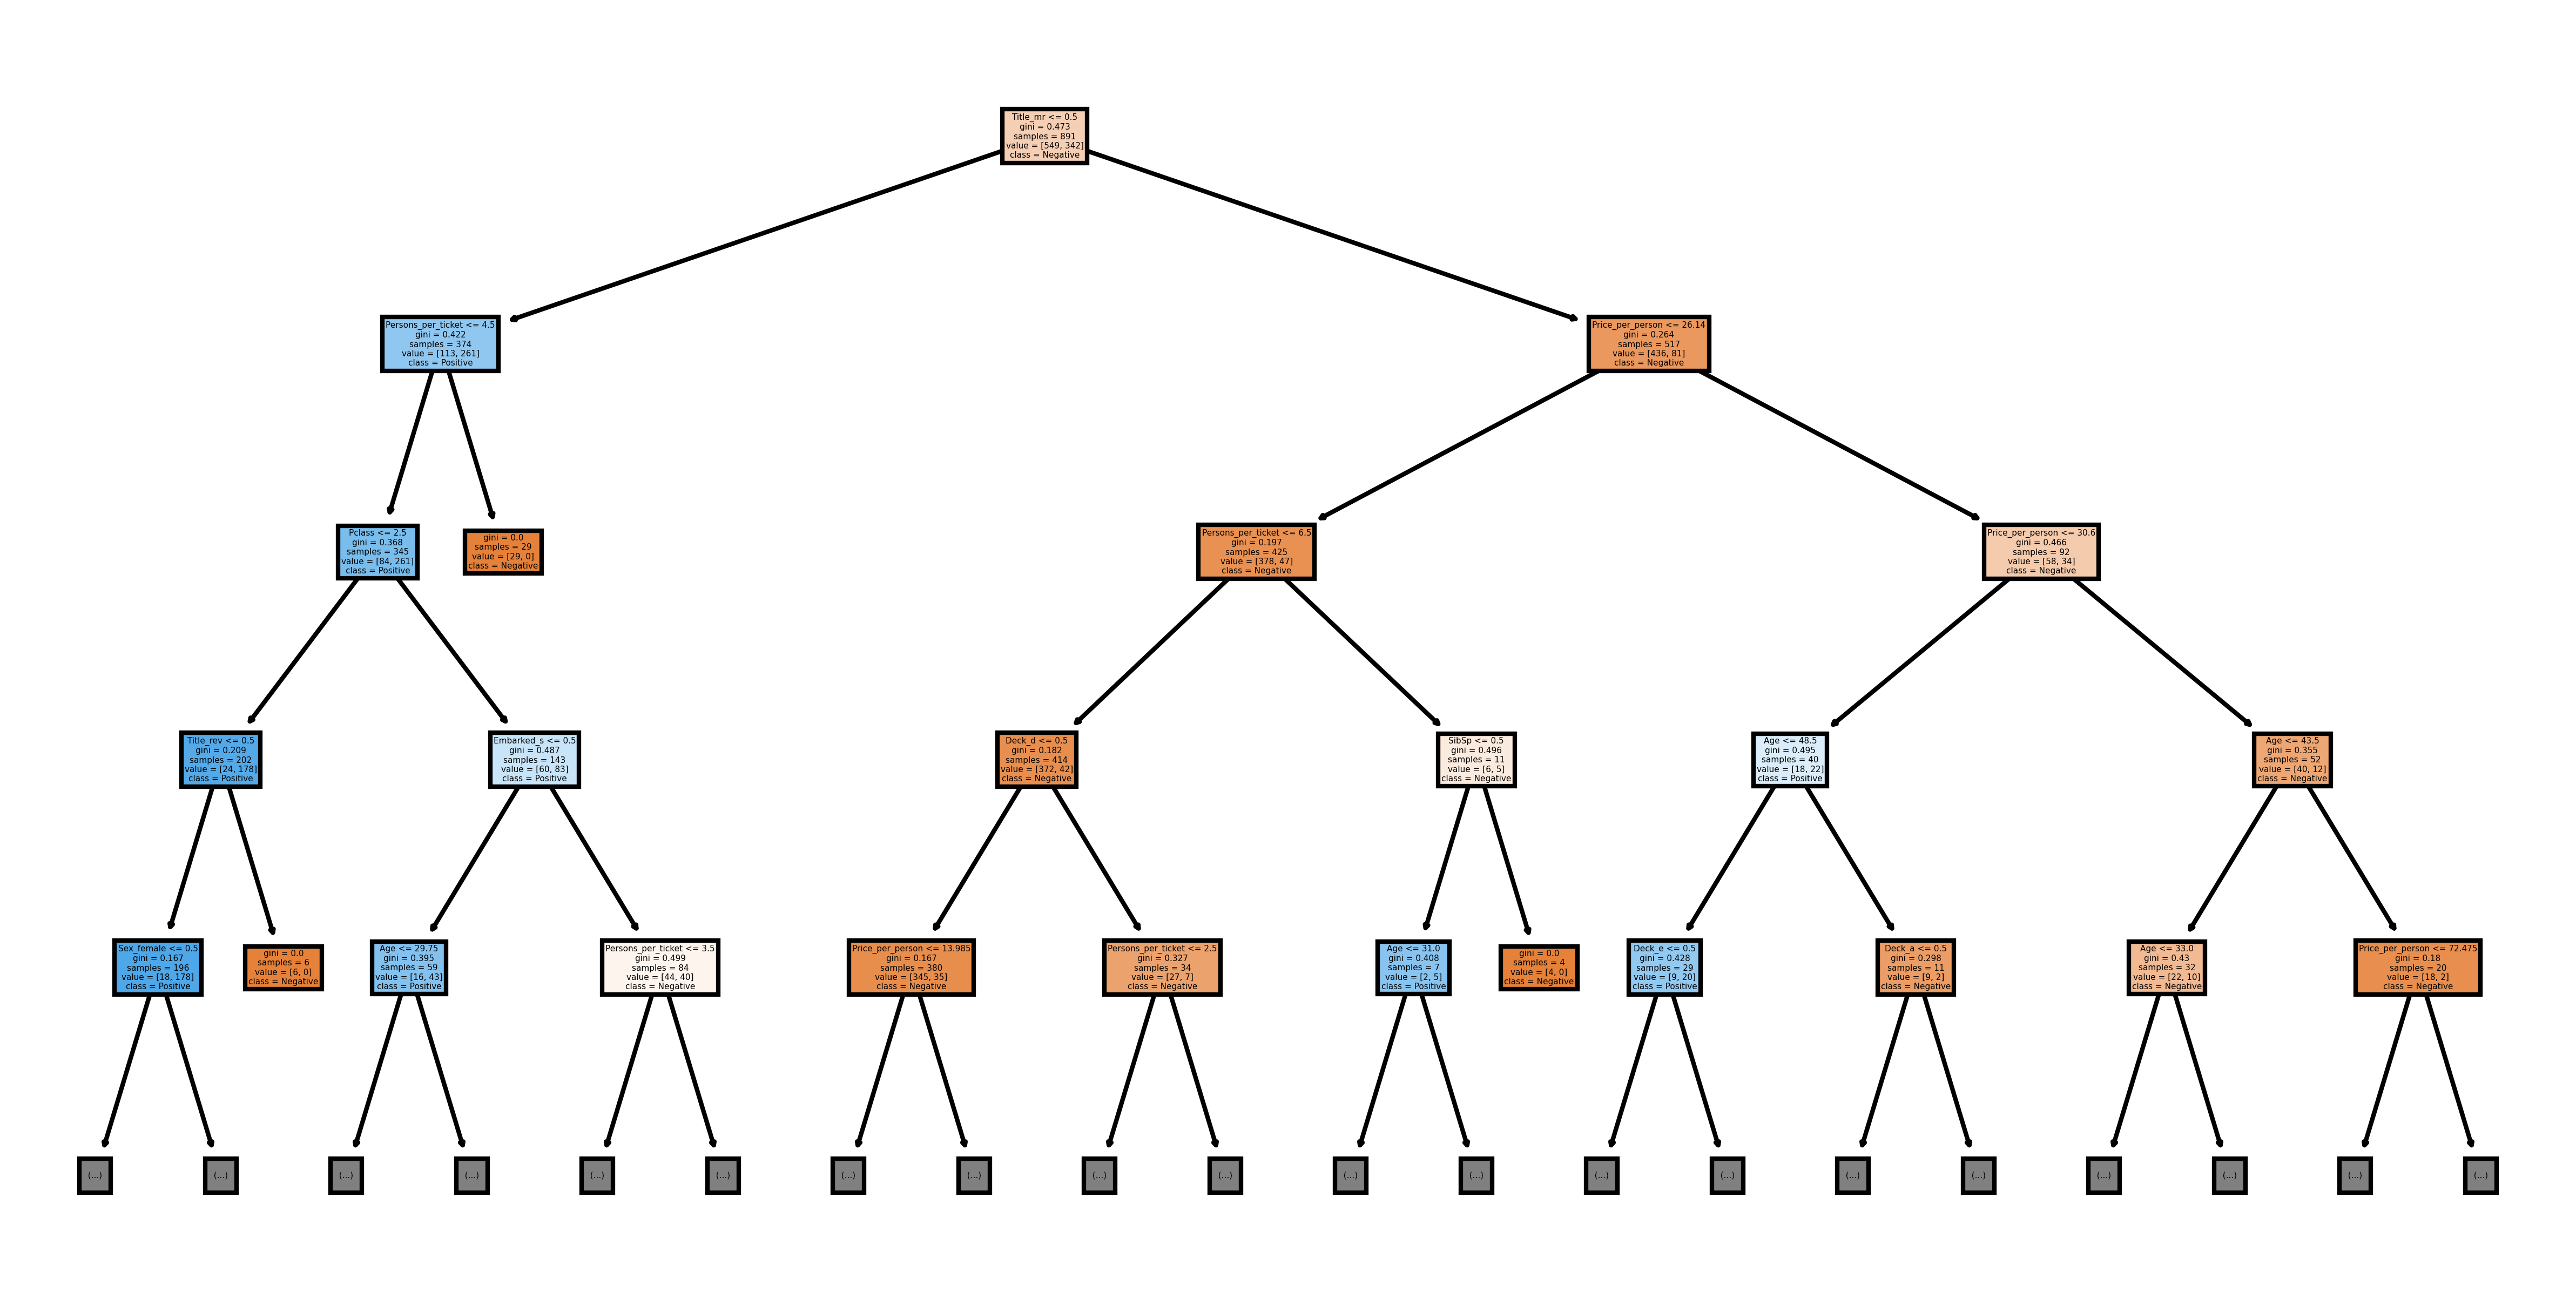

In [16]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,5), dpi=600)
tree.plot_tree(dtc, feature_names=list(X_train),max_depth=4,
               class_names = ['Negative','Positive'],
               filled = True);